In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import os
import itertools
import random
import sys
import powerlaw as pl
from networkx.drawing.nx_agraph import graphviz_layout
sys.path.append('/Users/css/dev/thesis/selfish_mining_abm/selfish_mining_abm')
import blockchain

# config

In [2]:
# PARAMETERS TO LOOP OVER
alpha = 0.3
# 1 minute equals 60'000 milliseconds.
gamma = 10

# Hand/pick selfish miners: "RANDOM", "BETWEENNESS"
# centrality_measures = ["RANDOM", "BETWEENNESS"]
centrality_measure = "RANDOM"

# available topologogies: "UNIFORM", "ER", "BA"
# topologies = ["UNIFORM", "ER", "BA"]
topology = "UNIFORM"

# available hashing power distributions: "UNIFORM", "POWERLAW", "EXPONENTIAL"
# hash_distributions = ["UNIFORM", "POWERLAW", "EXPONENTIAL"]
hash_distribution = "UNIFORM"

# SPECFIY TOPOLOGY
desired_avg_degree = 10  # applies to ER and RAND topology.
ba_m = 5  # relevant for BA topology; no. edges to attach from new node to existing nodes

# SPECIFY HASHING POWER DISTRIBUTION
pl_alpha = 2  # input parameter for powerlaw distribution
exp_lambda = 1  # input parameter for exponential distribution
# ADDITIONAL PARAMETERS
simulation_time = 100
number_of_nodes = 100
number_selfish_nodes = 1  # if there is more than 1 selfish miner, they act as "cartel"
number_honest_nodes = number_of_nodes - number_selfish_nodes
verbose = False

# set up

In [3]:
def set_up_topology(topology, number_of_nodes, desired_avg_degree, ba_m):
    # generate network depending on topology parameter
    if topology == "UNIFORM":
        net_p2p = nx.random_degree_sequence_graph(
            [desired_avg_degree for i in range(number_of_nodes)])

    elif topology == "ER":
        p = desired_avg_degree / number_of_nodes
        net_p2p = nx.fast_gnp_random_graph(number_of_nodes, p)

    elif topology == "BA":
        net_p2p = nx.barabasi_albert_graph(number_of_nodes, ba_m)

    # get largest connected component
    lcc_set = max(nx.connected_components(net_p2p), key=len)
    net_p2p = net_p2p.subgraph(lcc_set).copy()
    # some nodes may have been removed because they were not port of the lcc.
    # relabel nodes so that only nodes in lcc are labelled. (without it we run into problems where node labels are higher than the number of nodes -> loops run into indexing problems)
    net_p2p = nx.convert_node_labels_to_integers(
        net_p2p, first_label=0)

    # some nodes may have been removed as they were not part of the lcc -> update num nodes
    number_of_nodes = len(net_p2p)
    # (brute-forcing number of selfish nodes to stay unchanged)
    number_honest_nodes = number_of_nodes - number_selfish_nodes

    return net_p2p, number_honest_nodes

def set_up_hash_distr(net_p2p, centrality_measure, hash_distribution, number_selfish_nodes, number_honest_nodes, alpha):
    # make sure that when there are no selfish nodes that alpha is never unequal 0. (in case you want to simulate only honest nodes)
    assert not (number_selfish_nodes == 0 and alpha !=
                0), "Alpha unequal 0 with no selfish nodes"

    if hash_distribution == "UNIFORM":
        hashing_power_selfish = np.random.random(number_selfish_nodes)
        hashing_power_honest = np.random.random(number_honest_nodes)

    elif hash_distribution == "POWERLAW":
        power_distrib = pl.Power_Law(parameters=[pl_alpha], discrete=False)
        hashing_power_selfish = power_distrib.generate_random(
            number_selfish_nodes)
        hashing_power_honest = power_distrib.generate_random(
            number_honest_nodes)

    elif hash_distribution == "EXPONENTIAL":
        exp_distrib = pl.Exponential(parameters=[exp_lambda])
        hashing_power_selfish = exp_distrib.generate_random(
            number_selfish_nodes)
        hashing_power_honest = exp_distrib.generate_random(
            number_honest_nodes)

    # normalize vector so that sum of selfish hashing power equals alpha & honest hashing power equals 1-alpha.
    if number_selfish_nodes != 0:
        hashing_power_selfish /= sum(hashing_power_selfish)
        hashing_power_selfish *= alpha
    hashing_power_honest /= sum(hashing_power_honest) / (1 - alpha)

    # combine selfish and honest hashing power vectors together
    hashing_power_unsorted = np.append(
        hashing_power_selfish, hashing_power_honest)

    if centrality_measure == "RANDOM":
        # create an is_selfish vector that corresponds to the order of the hashing_power vector
        is_selfish = np.append(np.ones(number_selfish_nodes),
                                np.zeros(number_honest_nodes))

        # finally, randomize is_selfish and hashing_power arrays in unison
        randomize = np.arange(len(hashing_power_unsorted))
        np.random.shuffle(randomize)
        hashing_power = hashing_power_unsorted[randomize]
        is_selfish = is_selfish[randomize]

    elif centrality_measure == "BETWEENNESS":
        # compute betweenness centrality and sort it
        btwn = nx.betweenness_centrality(net_p2p)
        btwn_sorted = {k: v for k, v in sorted(
            btwn.items(), key=lambda item: item[1], reverse=True)}
        # return node indeces sorted for betweenness centrality
        btwn_sorted_indices = list(btwn_sorted.keys())

        selfish_indices = list(btwn_sorted.keys())[:number_selfish_nodes]
        honest_indices = list(btwn_sorted.keys())[
            number_selfish_nodes:len(btwn)]

        # set selifsh nodes according to betweenness centrality
        is_selfish = np.zeros(number_honest_nodes+number_selfish_nodes)
        for i in selfish_indices:
            is_selfish[i] = 1

        # sort hashing power vector so that selfish nodes are assigned correct hashing power
        hashing_power = hashing_power_unsorted.copy()
        for (index, value) in enumerate(btwn_sorted):
            hashing_power[value] = hashing_power_unsorted[index]

    return hashing_power, is_selfish

def set_up_model(
    centrality_measure, topology, hash_distribution, number_of_nodes, number_selfish_nodes, alpha, desired_avg_degree, ba_m
):
    net_p2p, number_honest_nodes = set_up_topology(
        topology, number_of_nodes, desired_avg_degree, ba_m)

    hashing_power, is_selfish = set_up_hash_distr(
        net_p2p, centrality_measure, hash_distribution, number_selfish_nodes, number_honest_nodes, alpha)

    return net_p2p, hashing_power, is_selfish

In [4]:
def simulate(centrality_measure, topology, hash_distribution, number_of_nodes, number_selfish_nodes, alpha, desired_avg_degree, ba_m):
    if alpha == 0:
        net_p2p, hashing_power, is_selfish = set_up_model(
            centrality_measure, topology, hash_distribution, number_of_nodes, number_selfish_nodes, 0, desired_avg_degree, ba_m
        )
    else:
        net_p2p, hashing_power, is_selfish = set_up_model(
            centrality_measure, topology, hash_distribution, number_of_nodes, number_selfish_nodes, alpha, desired_avg_degree, ba_m
        )

    model = blockchain.GillespieBlockchain(
        net_p2p, is_selfish, hashing_power, gamma, verbose=verbose
    )

    while model.time < simulation_time:
        model.next_event()
    model.block_tree.tag_main_chain()
    
    return model

# simulation

In [5]:
model = simulate(centrality_measure, topology, hash_distribution, number_of_nodes, number_selfish_nodes, alpha, desired_avg_degree, ba_m)

# plots

## probability of sibling race

In [6]:
def blocktree_plot(model):
    honest_blocks = []
    selfish_blocks = []
    
    for block in model.block_tree.tree.nodes():
        if model.block_tree[block]["miner_is_selfish"] == True:
            selfish_blocks.append(model.block_tree[block]["id"])
        else:
            honest_blocks.append(model.block_tree[block]["id"])

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 2), sharex=True, sharey=True)
    G = model.block_tree.tree
    H = G.reverse(copy=True)
    pos = graphviz_layout(H, prog='dot', args='-Grankdir="RL"')

    plt.title(r"Blockchain with Selfish Mining ($\alpha$ = {})".format(alpha))

    nx.draw_networkx_nodes(H,pos=pos, nodelist=honest_blocks, node_color='green', label="Honest miner", node_shape='s', node_size=200)
    nx.draw_networkx_nodes(H,pos=pos, nodelist=selfish_blocks, node_color='red', label="Selfish miner", node_shape='s', node_size=200)
    nx.draw_networkx_nodes(H,pos=pos, nodelist=[0], node_color='blue', label="Genesis block", node_shape='s', node_size=200)    

    nx.draw_networkx_edges(H, pos, arrows=True)
    nx.draw_networkx_labels(H, pos, font_size=10, font_color="white")
    plt.legend(labelspacing=0.8, fontsize=9, frameon=False, borderpad=0.1)
    plt.show()

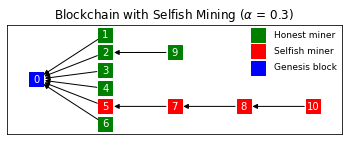

In [7]:
model = simulate(centrality_measure, topology, hash_distribution, number_of_nodes, number_selfish_nodes, alpha, desired_avg_degree, ba_m)
blocktree_plot(model)

In [8]:
def multi_blocktree_plot(model1, alpha1, model2, alpha2, saving=False):
    
    models = [model1, model2]
    alphas = [alpha1, alpha2]
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 2), frameon=True)
    # fig.suptitle("Blockchain with different levels of selfish mining", fontsize=14, y= 1.15)
    
    for (index, model) in enumerate(models):
        
        honest_blocks = []
        selfish_blocks = []

        for block in model.block_tree.tree.nodes():
            if model.block_tree[block]["miner_is_selfish"] == True:
                selfish_blocks.append(model.block_tree[block]["id"])
            else:
                honest_blocks.append(model.block_tree[block]["id"])
        
        G = model.block_tree.tree
        H = G.reverse(copy=True)
        pos = graphviz_layout(H, prog='dot', args='-Grankdir="RL"')

        axs[index].set_title(r"$\alpha$ = {}".format(alphas[index]))

        nx.draw_networkx_nodes(H, pos=pos, ax=axs[index], nodelist=honest_blocks, node_color='green', label="Honest miner", node_shape='s', node_size=200)
        nx.draw_networkx_nodes(H, pos=pos, ax=axs[index], nodelist=selfish_blocks, node_color='red', label="Selfish miner", node_shape='s', node_size=200)
        nx.draw_networkx_nodes(H, pos=pos, ax=axs[index], nodelist=[0], node_color='blue', label="Genesis block", node_shape='s', node_size=200)    

        nx.draw_networkx_edges(H, pos, ax=axs[index], arrows=True)
        nx.draw_networkx_labels(H, pos, ax=axs[index], font_size=10, font_color="white")
        
        axs[index].set_frame_on(False)
        
    plt.legend(bbox_to_anchor=[0, 1], labelspacing=0.8, fontsize=9, frameon=False, borderpad=0.1)
    plt.savefig("sm_visualization.png")
    
    fig_filename = "sm_visualization.png"
    parent_dir = os.path.dirname('/Users/css/dev/thesis/selfish_mining_abm/notebooks')
    path = parent_dir + f"/notebooks/figures/{fig_filename}"
    if saving:
        plt.savefig(path, bbox_inches="tight")
    plt.show()

In [9]:
gamma = 0.01 # tau

alpha1 = 0.2
alpha2 = 0.4

# model11 = simulate(centrality_measure, topology, hash_distribution, number_of_nodes, number_selfish_nodes, alpha1, desired_avg_degree, ba_m)
# model2 = simulate(centrality_measure, topology, hash_distribution, number_of_nodes, number_selfish_nodes, alpha2, desired_avg_degree, ba_m)

multi_blocktree_plot(model11, alpha1, model2, alpha2, saving=True)

NameError: name 'model11' is not defined

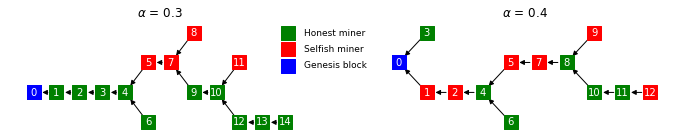

In [15]:
gamma = 0.01 # tau

alpha1 = 0.2
alpha2 = 0.4

modela = simulate(centrality_measure, topology, hash_distribution, number_of_nodes, number_selfish_nodes, alpha1, desired_avg_degree, ba_m)
modelb = simulate(centrality_measure, topology, hash_distribution, number_of_nodes, number_selfish_nodes, alpha2, desired_avg_degree, ba_m)

multi_blocktree_plot(modela, alpha, modelb, alpha2, saving=True)